In [3]:
!pip install torch_geometric

  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, matthews_corrcoef
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

In [7]:
# Load datasets
X_train = pd.read_csv("X_train.csv")  # Peptide sequences
train_labels = pd.read_csv("label_train.csv")  # Corresponding labels

# Combine features and labels
train_data = pd.concat([X_train, train_labels], axis=1)
train_data.columns = ['peptide_sequence', 'label']

# Load test data
X_test = pd.read_csv("X_test.csv")
test_labels = pd.read_csv("label_test.csv")
test_data = pd.concat([X_test, test_labels], axis=1)
test_data.columns = ['peptide_sequence', 'label']


In [8]:
train_data.head()

,peptide_sequence,label
0,EGNRPTNSIVFTKLT,1
1,TRQGGYSNDNTVIFR,1
2,LHGETFPYTAFDNNC,1
3,VMALEPVVGAAIAAP,1
4,YIMSGPARYVYFHMVLPVEAQ,1


In [9]:
test_data.head()

,peptide_sequence,label
0,HPGNTILHVDTIYNRPSNTT,1
1,YWAGIEFDVTHKGMALLHRL,1
2,EQGLLYMPQELAVSD,1
3,GARGFFQARHLEMDA,1
4,GMLQGRGPLKLFMAL,1


In [10]:
train_data.shape

(2871, 2)

In [11]:
test_data.shape

(341, 2)

In [12]:
X_train = train_data["peptide_sequence"]
y_train = train_data["label"]
X_test = test_data["peptide_sequence"]
y_test = test_data["label"]

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import combinations

# Function to generate gapped n-grams
def gapped_ngrams(sequence, n, gap=1):
    """
    Generate gapped n-grams from a given sequence.
    :param sequence: The peptide sequence (string)
    :param n: The size of the n-gram (e.g., 2 for bigram, 3 for trigram)
    :param gap: The number of characters skipped between components of the n-gram
    :return: A list of gapped n-grams
    """
    ngrams = []
    indices = list(range(len(sequence)))

    for comb in combinations(indices, n):
        if max(comb) - min(comb) <= (n - 1) + gap:
            ngrams.append(''.join(sequence[i] for i in comb))

    return ngrams

# Apply gapped n-gram transformation
def transform_sequences(sequences, n, gap):
    transformed = [' '.join(gapped_ngrams(seq, n, gap)) for seq in sequences]
    return transformed

# Apply Gapped Bigrams and Trigrams
gapped_bigrams_train = transform_sequences(X_train, n=2, gap=1)
gapped_trigrams_train = transform_sequences(X_train, n=3, gap=1)

gapped_bigrams_test = transform_sequences(X_test, n=2, gap=1)
gapped_trigrams_test = transform_sequences(X_test, n=3, gap=1)

# Combine bigrams & trigrams
X_train_gapped = [b + " " + t for b, t in zip(gapped_bigrams_train, gapped_trigrams_train)]
X_test_gapped = [b + " " + t for b, t in zip(gapped_bigrams_test, gapped_trigrams_test)]

# Apply TF-IDF on Gapped N-grams
tfidf = TfidfVectorizer(analyzer='word')  # Using 'word' since sequences are already processed as space-separated tokens
X_train_tfidf = tfidf.fit_transform(X_train_gapped)
X_test_tfidf = tfidf.transform(X_test_gapped)

In [15]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

In [16]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Build Graph (Random Graph Structure)
G = nx.random_geometric_graph(X_train_tensor.shape[0], radius=0.2)
edge_index = torch.tensor(list(G.edges)).t().contiguous()

# Convert to PyG data format
graph_data = Data(x=X_train_tensor, edge_index=edge_index, y=y_train_tensor)

# Define GCN Model
class GCN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

In [17]:
# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features=X_train_tensor.shape[1], num_classes=len(y_train.unique())).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

train_accuracies, val_accuracies, train_losses = [], [], []
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(graph_data)
    loss = criterion(out, graph_data.y)
    loss.backward()
    optimizer.step()

    # Compute training accuracy
    train_predictions = out.argmax(dim=1)
    train_acc = accuracy_score(graph_data.y.cpu(), train_predictions.cpu())
    train_accuracies.append(train_acc)
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_out = model(graph_data)
        val_predictions = val_out.argmax(dim=1)
        val_acc = accuracy_score(graph_data.y.cpu(), val_predictions.cpu())
        val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Loss {loss.item():.4f}, Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}")

Epoch 1: Loss 0.6936, Train Acc 0.4736, Val Acc 0.5682
Epoch 2: Loss 0.6749, Train Acc 0.5682, Val Acc 0.7099
Epoch 3: Loss 0.6471, Train Acc 0.7099, Val Acc 0.7784
Epoch 4: Loss 0.6202, Train Acc 0.7784, Val Acc 0.8058
Epoch 5: Loss 0.5934, Train Acc 0.8058, Val Acc 0.8162
Epoch 6: Loss 0.5684, Train Acc 0.8162, Val Acc 0.8159
Epoch 7: Loss 0.5482, Train Acc 0.8159, Val Acc 0.8196
Epoch 8: Loss 0.5323, Train Acc 0.8196, Val Acc 0.8215
Epoch 9: Loss 0.5204, Train Acc 0.8215, Val Acc 0.8264
Epoch 10: Loss 0.5113, Train Acc 0.8264, Val Acc 0.8215
Epoch 11: Loss 0.5051, Train Acc 0.8215, Val Acc 0.8288
Epoch 12: Loss 0.5004, Train Acc 0.8288, Val Acc 0.8122
Epoch 13: Loss 0.4983, Train Acc 0.8122, Val Acc 0.8334
Epoch 14: Loss 0.4986, Train Acc 0.8334, Val Acc 0.7883
Epoch 15: Loss 0.4992, Train Acc 0.7883, Val Acc 0.8328
Epoch 16: Loss 0.4926, Train Acc 0.8328, Val Acc 0.8365
Epoch 17: Loss 0.4940, Train Acc 0.8365, Val Acc 0.8058
Epoch 18: Loss 0.4944, Train Acc 0.8058, Val Acc 0.8297
E

In [18]:
# Compute MCC Score
mcc_score = matthews_corrcoef(graph_data.y.cpu(), val_predictions.cpu())
print(f"Matthews Correlation Coefficient (MCC): {mcc_score:.4f}")

Matthews Correlation Coefficient (MCC): 0.7025


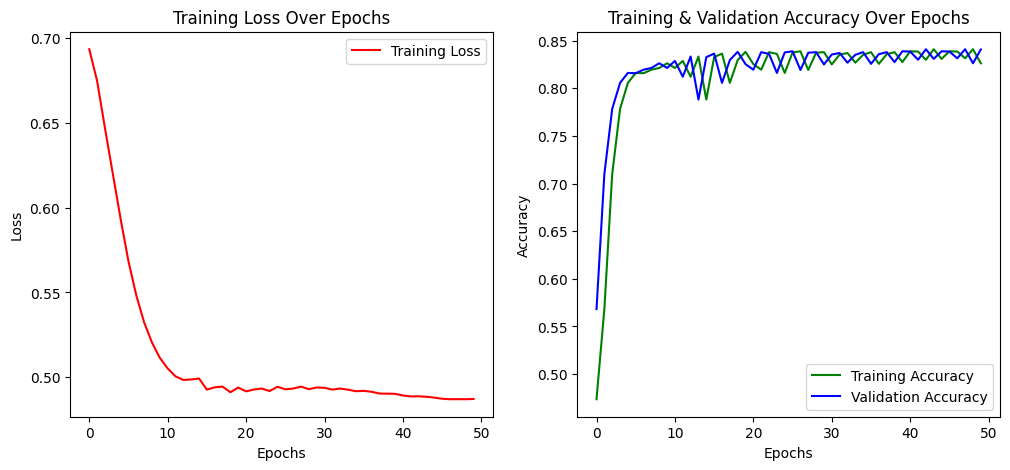

In [19]:
# Plot Training Accuracy, Validation Accuracy, and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label="Training Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label="Training Accuracy", color='green')
plt.plot(range(num_epochs), val_accuracies, label="Validation Accuracy", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()

plt.show()


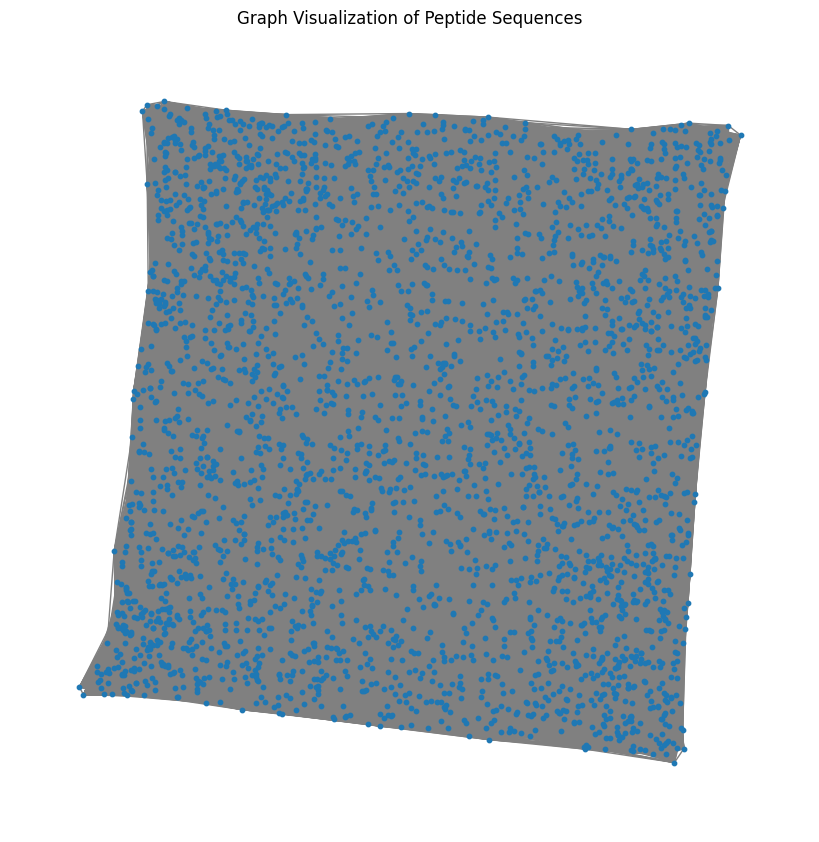

In [20]:
# Visualize Graph
plt.figure(figsize=(8, 8))
nx.draw(G, node_size=10, edge_color='gray')
plt.title("Graph Visualization of Peptide Sequences")
plt.show()